[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [ ]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [2]:
# i HAVE USED AN ENV FILE INSTEAD OF THE ABOVE OPTIONS
from dotenv import load_dotenv
load_dotenv(dotenv_path="C:/Users/riyaa/Documents/code/mat496/langgraphmod2/.env", override=True)

True

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"I heard you're looking for fantasy book recommendations?", name="BookBot")]
messages.append(HumanMessage(f"Yes, I love epic fantasy. What would you recommend for someone who enjoyed Lord of the Rings?", name="Riya"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: BookBot

I heard you're looking for fantasy book recommendations?
================================ Human Message =================================
Name: Riya

Yes, I love epic fantasy. What would you recommend for someone who enjoyed Lord of the Rings?


Recall we can pass them to a chat model.

In [6]:
!pip install langchain_google_genai

  Using cached grpcio-1.76.0-cp313-cp313-win_amd64.whl.metadata (3.8 kB)
  Using cached googleapis_common_protos-1.71.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ---------------------- ----------------- 0.8/1.4 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 2.7 MB/s eta 0:00:00
Using cached googleapis_common_protos-1.71.0-py3-none-any.whl (294 kB)
Using cached grpcio-1.76.0-cp313-cp313-win_amd64.whl (4.7 MB)
Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl (436 kB)

   --- ------------------------------------  1/11 [rsa]
  Attempting uninstall: protobuf
   --- ------------------------------------  1/11 [rsa]
    Found existing installation: protobuf 5.29.3
   --- ------------------------------------  1/11 [rsa]
   ------- --------------------

In [9]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
llm.invoke(messages)

AIMessage(content='Okay, excellent! Since you enjoyed Lord of the Rings, you\'re likely looking for something with a grand scope, detailed world-building, and a classic struggle between good and evil. Here are a few recommendations, categorized by what aspect of LotR they most emulate:\n\n**If you loved the World-Building and Deep Lore:**\n\n*   **The Wheel of Time series by Robert Jordan (and Brandon Sanderson):** This is a *massive* series (14 books + a prequel). It features a complex magic system, diverse cultures, a prophecy-driven narrative, and a large cast of characters. It\'s a long commitment, but the world is incredibly immersive. Be warned that the pacing can be slow in the middle books, but Sanderson really brings it home for the ending.\n*   **The Malazan Book of the Fallen by Steven Erikson:** This series is known for its incredibly dense and complex world-building, with a rich history and mythology. It\'s challenging to get into at first, as Erikson throws you right into

We can run our chat model in a simple graph with `MessagesState`.

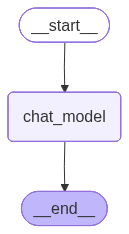

In [10]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: BookBot

I heard you're looking for fantasy book recommendations?
================================ Human Message =================================
Name: Riya

Yes, I love epic fantasy. What would you recommend for someone who enjoyed Lord of the Rings?
================================== Ai Message ==================================

Okay, excellent! If you loved Lord of the Rings, here are a few recommendations, categorized by what aspects of LOTR they capture:

**For a similar sense of epic scope, world-building, and deep history:**

*   **The Wheel of Time by Robert Jordan (and finished by Brandon Sanderson):** This is often considered the closest in scope to LOTR. It features a vast world with complex cultures, a battle between good and evil, and a Chosen One destined to save the world. Be warned, it's a very long series (14 books + a prequel), but many find it incredibly rewarding. It has a slow 

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

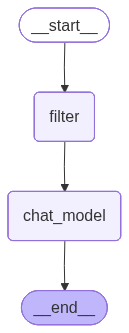

In [13]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="BookBot", id="1")]
messages.append(HumanMessage("Hi.", name="Riya", id="2"))
messages.append(AIMessage("What kind of books are you interested in?", name="BookBot", id="3"))
messages.append(HumanMessage("I love historical fiction like Babel or The Poppy War. Any recommendations?", name="Riya", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: BookBot

What kind of books are you interested in?
================================ Human Message =================================
Name: Riya

I love historical fiction like Babel or The Poppy War. Any recommendations?
================================== Ai Message ==================================

Okay, based on your love for historical fiction like Babel and The Poppy War, which are both excellent and share some common themes, here are some recommendations, broken down by the elements you might enjoy from those books:

**If you like the intricate world-building, historical detail, and moral complexity like in Babel:**

*   **Jonathan Strange & Mr Norrell by Susanna Clarke:** A dense but rewarding read set in 19th-century England, where magic has faded but is slowly being revived. It has a similar atmosphere of academia, historical detail, and the re-emergence of something powerful and potentially

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

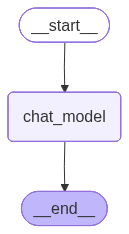

In [15]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about historical fiction classics!", name="Riya"))

In [17]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: BookBot

Hi.
================================ Human Message =================================
Name: Riya

Hi.
================================== Ai Message ==================================
Name: BookBot

What kind of books are you interested in?
================================ Human Message =================================
Name: Riya

I love historical fiction like Babel or The Poppy War. Any recommendations?
================================== Ai Message ==================================

Okay, based on your love for historical fiction like Babel and The Poppy War, which are both excellent and share some common themes, here are some recommendations, broken down by the elements you might enjoy from those books:

**If you like the intricate world-building, historical detail, and moral complexity like in Babel:**

*   **Jonathan Strange & Mr Norrell by Susanna Clarke:** A dense but rewarding read s

In [18]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: BookBot

Hi.
================================ Human Message =================================
Name: Riya

Hi.
================================== Ai Message ==================================
Name: BookBot

What kind of books are you interested in?
================================ Human Message =================================
Name: Riya

I love historical fiction like Babel or The Poppy War. Any recommendations?
================================== Ai Message ==================================

Okay, based on your love for historical fiction like Babel and The Poppy War, which are both excellent and share some common themes, here are some recommendations, broken down by the elements you might enjoy from those books:

**If you like the intricate world-building, historical detail, and moral complexity like in Babel:**

*   **Jonathan Strange & Mr Norrell by Susanna Clarke:** A dense but rewarding read s

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

In [ ]:
#screenshot of langsmith trace in README.md file

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

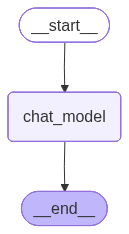

In [23]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-2.0-flash"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me about Brandon Sanderson's work and what I might like most from his catalogue if I like high fantasy novels!", name="Riya"))

In [25]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatGoogleGenerativeAI(model="gemini-2.0-flash"),
            allow_partial=False
        )

[HumanMessage(content="Tell me about Brandon Sanderson's work and what I might like most from his catalogue if I like high fantasy novels!", additional_kwargs={}, response_metadata={}, name='Riya')]

In [26]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

In [ ]:
#langsmith trace screenshot is in README.md !!!